In [56]:
import pandana as pdna
import pandas as pd
import geopandas as gpd

import matplotlib
from matplotlib import pyplot as plt
import h3

Before running this notebook, first create the walk and bike network using the notebook save_osm_networks.ipynb

# Create the Pandana network(s)

In [102]:
networks={}
for mode in ['walk', 'bike']:
    print(mode)
    nodes=pd.read_csv('./outputs/networks/{}_nodes.csv'.format(mode), index_col=0)
    edges=pd.read_csv('./outputs/networks/{}_edges.csv'.format(mode), index_col=0)
    net = pdna.Network(nodes["x"],
                   nodes["y"],
                   edges["from"],
                   edges["to"],
                   edges[["weight"]], 
                   twoway=False)
    net.nodes_df['h3']=net.nodes_df.apply(lambda row: h3.geo_to_h3(lat=row['y'], lng=row['x'], 
                                                     resolution=10), axis=1)
    networks[mode]=net

walk
Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 71240
Setting CH edge vector of size 638552
Range graph removed 923024 edges of 1277104
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
bike
Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 51322
Setting CH edge vector of size 271873
Range graph removed 350520 edges of 543746
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


# Get the POI Data

## Get Lat and Long from Addresses


In [10]:
from geopy.geocoders import Nominatim
# can be improved, as the latitude and longitude do not consider the address number
geolocator = Nominatim(user_agent="CS-Rome")

def extract_lat_long_from_address(df, address_col, address_suffix):
    df['latitude'] = ""
    df['longitude'] = ""
    for index,row in df.iterrows():
        address = row[address_col]
        try:
            location = geolocator.geocode(address + address_suffix)
            df.loc[index,['latitude']] = location.latitude
            df.loc[index,['longitude']] = location.longitude
        except:
            print('Error while managing address: ', address)

## Accomodations

In [11]:
ACCOMODATION_DATA_LOC='https://dati.comune.roma.it/catalog/dataset/d51c988e-3e09-4175-9f6f-d3d61599417d/resource/d711888d-c4fb-4988-9a21-7783d65425c5/download/suar2021-08.csv'

In [12]:
accommodation=pd.read_csv(ACCOMODATION_DATA_LOC, sep=';')

/opt/anaconda3/envs/ntt/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
accommodation.head()

,id,tipologia,denominazione,via,civico,latitude,longitude,stelle,categoria,totalePostiLetto,...,spaccio,campiBocce,campoBeachVolley,campoCalcetto,campoPallavolo,attraccoNatanti,numeroBungalow,numeroDocce,numeroLavadini,numeroPiazzole
0,338189,Guest House o Affittacamere,00146 ROMA HOLIDAY AND JUBILEE HOUSE,Via Efeso,19,41.854266,12.474979,NaN,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,336739,Guest House o Affittacamere,126 GRACCHI SUITES GUEST HOUSE O AFFITTACAMERE,Via dei Gracchi,126,41.908495,12.463876,NaN,2.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,335666,Guest House o Affittacamere,149 GUEST HOUSE,Via Marmorata,149,41.881459,12.476980,NaN,2.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,336886,Guest House o Affittacamere,1880 ATYPICAL ROOMS,Via Nazionale,66,41.899339,12.491388,NaN,2.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,337239,Guest House o Affittacamere,19 STEPS TREVI GUEST HOUSE O AFFITTACAMERE,Via dei Crociferi,26,41.900808,12.481812,NaN,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
accommodation.groupby('tipologia').size()

tipologia
Agriturismi                          23
Alberghi                            883
Alloggi per uso turistico          8332
Bed and Breakfast                  1413
Campeggi                             17
Case e appartamenti per vacanze    5418
Case per ferie                      246
Dipendenze alberghiere               67
Guest House o Affittacamere        2993
Ostelli per la gioventù              20
Residence                            33
dtype: int64

Remove entries with invalid lat and lon to avoid errors in pandana analysis

In [15]:
print(len(accommodation))
accommodation=accommodation.loc[
    ((~accommodation['longitude'].isnull())&
     (~accommodation['latitude'].isnull()))
]
print(len(accommodation))

19445
19411


<AxesSubplot:>

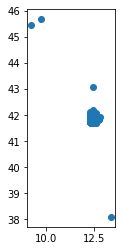

In [16]:
accommodation_gdf=gpd.GeoDataFrame(data=accommodation,geometry=gpd.points_from_xy(
    x=accommodation.longitude, 
    y=accommodation.latitude, 
    crs='EPSG:4326'))
accommodation_gdf.plot()

In [17]:
accommodation_gdf.to_file('./outputs/accomodation.geojson', 
                          driver='GeoJSON')

## Public transport stops

In [18]:
TRANSPORT_STOPS_DATA_LOC='https://dati.comune.roma.it/catalog/dataset/a7dadb4a-66ae-4eff-8ded-a102064702ba/resource/266d82e1-ba53-4510-8a81-370880c4678f/download/rome_static_gtfs_test.zip'

In [19]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

resp = urlopen(TRANSPORT_STOPS_DATA_LOC)
zipfile = ZipFile(BytesIO(resp.read()))

In [20]:
transport_stops=pd.read_csv(zipfile.open('stops.txt'), sep=',')
transport_stops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,stop_url,wheelchair_boarding,stop_timezone,location_type,parent_station
0,82513,82513,ARDEATINA/CIVICO 802,NaN,41.808448,12.530260,NaN,NaN,NaN,NaN,NaN
1,82922,82922,ARDEATINA/GROTTA PERFETTA,NaN,41.828838,12.518260,NaN,NaN,NaN,NaN,NaN
2,72923,72923,ARTE/AMERICA,NaN,41.828333,12.473870,NaN,NaN,NaN,NaN,NaN
3,78603,78603,ASCARELLI/CASALE LUMBROSO,NaN,41.868455,12.360537,NaN,NaN,NaN,NaN,NaN
4,80560,80560,ASCARELLI/MOSCA,NaN,41.868777,12.357487,NaN,NaN,NaN,NaN,NaN


## Municipal Sport Centers

In [21]:
SPORTS_DATA_LOC='https://dati.comune.roma.it/catalog/dataset/acb9bbf0-9beb-409d-b5e8-b4407dec1aef/resource/809dfc0d-f305-4b9e-a487-2b4ce7fd5b0c/download/centri_sportivi_municipali_2018.csv'

In [22]:
sports_centers=pd.read_csv(SPORTS_DATA_LOC, sep=';',encoding = "latin")

In [23]:
sports_centers

,ID,MUNICIPIO,ISTITUTO COMPRENSIVO,CENTRO SPORTIVO MUNICIPALE,INDIRIZZO,LARGHEZZA,LUNGHEZZA,ALTEZZA,SPOGLIATOI,STATO MANUTENTIVO,NOTE
0,1,I,I.C. Via delle Carine,Plesso Mazzini,"Via delle Carine, 2",9,"14,2",5,si,discreto,NaN
1,2,I,I.C. Regina Elena,Plesso R. Elena,"Via Puglie, 6",9,18,6,si,discreto,NaN
2,3,I,I.C. Regina Elena,Plesso Pestalozzi,"Via Montebello, 118","9,5","10,5",6,no,mediocre,NaN
3,4,I,I.C. Virgilio,Plesso Cadlolo,"Via della Rondinella, 2",9,20,7,no,discreto,NaN
4,5,I,I.C. Dante Alighieri,Plesso Cassiodoro,"Via Cassiodoro, 2B",12,"23,7",7,si,ottimo,NaN
...,...,...,...,...,...,...,...,...,...,...,...
357,358,XV,NaN,Enzo Biagi - Angelini - M. Periello,"Via Quero, 130","10,5","20,7",NaN,si,buono,NaN
358,359,XV,NaN,Karol Wojtyla - Sede centrale,"Via Concesio, 2","11,5","23,85",6,si,discreto,NaN
359,360,XV,NaN,Karol Wojtyla - Plesso,"Largo Giampaolo Borghi, 6","12,3","24,55",NaN,si,discreto,NaN
360,361,XV,NaN,Parco di Veio - Sede Centrale,Via Fosso del Fontaniletto,"11,1","22,45",6,si,buono,NaN


In [24]:
sports_centers["INDIRIZZO"]=sports_centers["INDIRIZZO"].apply(str)
# Fixing addresses withouth address number
for index,row in sports_centers.iterrows():
    if ', SNC' in row['INDIRIZZO']:
        sports_centers.loc[index,['INDIRIZZO']] = row['INDIRIZZO'].replace(', SNC', ', 1')

In [25]:
extract_lat_long_from_address(sports_centers, address_col="INDIRIZZO", address_suffix=", Roma, Roma Capitale, Lazio, Italia")

Error while managing address:  P.le deglie Eroi, 14
Error while managing address:  Via S.M. Goretti, 43
Error while managing address:  Piazza Ruggero da Sicilia, 2
Error while managing address:  Via R. Calabria, 48
Error while managing address:  Via G. da Procida, 16 
Error while managing address:  Via G. da Procida, 16 
Error while managing address:  Via J. Pintor, 6
Error while managing address:  Via Don G. M. Mussolillo, 64
Error while managing address:  Via F. andò, 15
Error while managing address:  Via Antonio Serassi,75
Error while managing address:  Via V. mezzogiorno, 20
Error while managing address:  Via Scalo di Settebagni, 45
Error while managing address:  Via Scalo di Settebagni, 45
Error while managing address:  Via G. De Santis, 27
Error while managing address:  Via C. Angiolieri, 15
Error while managing address:  Via Saffiano, 34
Error while managing address:  Via M. Baldo, 2
Error while managing address:  Via Casal Bianco, 140
Error while managing address:  Via N.M. Nic

In [26]:
#removing rows withouth coordinates
sports_centers.replace("", float("NaN"), inplace=True)
sports_centers["latitude"]=sports_centers["latitude"].apply(float)
sports_centers["longitude"]=sports_centers["longitude"].apply(float)
sports_centers.dropna(subset = ["latitude", "longitude"], inplace=True)

In [27]:
sports_centers

,ID,MUNICIPIO,ISTITUTO COMPRENSIVO,CENTRO SPORTIVO MUNICIPALE,INDIRIZZO,LARGHEZZA,LUNGHEZZA,ALTEZZA,SPOGLIATOI,STATO MANUTENTIVO,NOTE,latitude,longitude
0,1,I,I.C. Via delle Carine,Plesso Mazzini,"Via delle Carine, 2",9,"14,2",5,si,discreto,NaN,41.892553,12.490998
1,2,I,I.C. Regina Elena,Plesso R. Elena,"Via Puglie, 6",9,18,6,si,discreto,NaN,41.910432,12.495173
2,3,I,I.C. Regina Elena,Plesso Pestalozzi,"Via Montebello, 118","9,5","10,5",6,no,mediocre,NaN,41.906285,12.501176
3,4,I,I.C. Virgilio,Plesso Cadlolo,"Via della Rondinella, 2",9,20,7,no,discreto,NaN,41.901138,12.468548
4,5,I,I.C. Dante Alighieri,Plesso Cassiodoro,"Via Cassiodoro, 2B",12,"23,7",7,si,ottimo,NaN,41.906183,12.465886
...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,358,XV,NaN,Enzo Biagi - Angelini - M. Periello,"Via Quero, 130","10,5","20,7",NaN,si,buono,NaN,42.040546,12.306673
358,359,XV,NaN,Karol Wojtyla - Sede centrale,"Via Concesio, 2","11,5","23,85",6,si,discreto,NaN,42.003132,12.485830
359,360,XV,NaN,Karol Wojtyla - Plesso,"Largo Giampaolo Borghi, 6","12,3","24,55",NaN,si,discreto,NaN,42.008192,12.479552
360,361,XV,NaN,Parco di Veio - Sede Centrale,Via Fosso del Fontaniletto,"11,1","22,45",6,si,buono,NaN,41.973973,12.438325


In [28]:
sports_centers.groupby('MUNICIPIO').size()

MUNICIPIO
I       11
II      10
III     25
IV      13
IX       3
V       28
VI      39
VIII    11
XI      10
XII     11
XIII    14
XIV     17
XV      26
dtype: int64

In [29]:
sports_centers.groupby('STATO MANUTENTIVO').size()

STATO MANUTENTIVO
buone                                            1
buono                                           46
buonoo                                           1
cattivo                                          4
discreto                                        28
idoneo all'affidamento                          25
idoneo per attività sportive                    38
inagibile per lavori in corso alle strutture     1
mediocre                                        17
necessita manutenzione                           1
necessità interventi                             1
ottimo                                           3
palestra in ristrutturazione                     1
pavimentazione necessità manutenzione            1
pessimo                                          2
pessimo, non agibile                             1
sufficiente                                      2
dtype: int64

# Public Libraries

In [30]:
LIBS_LOC='dataset/DATI_BIBLIOTECHE_EXCEL_01.xls'

In [31]:
libs = pd.read_excel(LIBS_LOC, sheet_name='Report personalizzato')  
libs.head()

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/DATI_BIBLIOTECHE_EXCEL_01.xls'

In [32]:
extract_lat_long_from_address(libs, address_col="indirizzo", address_suffix=", Roma, Italia")

NameError: name 'libs' is not defined

In [33]:
#removing rows withouth coordinates
libs.replace("", float("NaN"), inplace=True)
libs["latitude"]=libs["latitude"].apply(float)
libs["longitude"]=libs["longitude"].apply(float)
libs.dropna(subset = ["latitude", "longitude"], inplace=True)

NameError: name 'libs' is not defined

## Primary Schools

In [34]:
SCHOOLS_DATA_LOC='https://dati.comune.roma.it/catalog/dataset/752549b2-a55b-4de1-acb0-e638876c0fb1/resource/e31f7557-1659-46eb-b2a6-0f908a6a7d33/download/02-infanzia_09-10.csv'

In [35]:
schools=pd.read_csv(SCHOOLS_DATA_LOC, sep=';',encoding = "latin")
schools = schools.dropna()

In [36]:
schools.head()

,Municipio,Codice scuola,Nome scuola,Indirizzo,Telefono,Orario entrata/uscita,Corsi attivi,Totale capienza,Totale iscritti,Iscritti maschi,Iscritti femmine,Iscritti italiani,Iscritti non italiani
0,I,3557.0,A. BACCARINI,"Via Sforza, 2",06/4883788,08:00 / 17:00,3.0,75.0,65.0,35.0,30.0,58.0,7.0
1,I,3549.0,A. CADLOLO,"Via Della Rondinella, 2",06/68802521,08:00 / 17:00,4.0,100.0,93.0,48.0,45.0,87.0,6.0
2,I,2886.0,ADELAIDE CAIROLI,"Via Giordano Bruno, 2",06/39738646,08:00 / 17:00,9.0,217.0,207.0,93.0,114.0,171.0,36.0
3,I,3553.0,E.GIANTURCO,"Via Della Palombella, 4",06/68307753,08:00 / 17:00,3.0,63.0,55.0,32.0,23.0,53.0,2.0
4,I,3556.0,E.PESTALOZZI,"Via Mentana, 1",06/4941465,08:00 / 17:00,2.0,50.0,36.0,18.0,18.0,30.0,6.0


In [37]:
schools.groupby('Municipio').size()

Municipio
I       22
II      15
III     13
IV      26
IX      26
V       19
VI      13
VII     32
VIII    18
X       10
XI      16
XII     11
XIII    17
XIV     14
XV      15
dtype: int64

In [38]:
# Fixing addresses withouth address number
for index,row in schools.iterrows():
    if ', SNC' in row['Indirizzo']:
        schools.loc[index,['Indirizzo']] = row['Indirizzo'].replace(', SNC', ', 1')

In [39]:
extract_lat_long_from_address(schools, address_col="Indirizzo", address_suffix=", Roma, Italia")

In [40]:
schools.head()

,Municipio,Codice scuola,Nome scuola,Indirizzo,Telefono,Orario entrata/uscita,Corsi attivi,Totale capienza,Totale iscritti,Iscritti maschi,Iscritti femmine,Iscritti italiani,Iscritti non italiani,latitude,longitude
0,I,3557.0,A. BACCARINI,"Via Sforza, 2",06/4883788,08:00 / 17:00,3.0,75.0,65.0,35.0,30.0,58.0,7.0,41.895706,12.495319
1,I,3549.0,A. CADLOLO,"Via Della Rondinella, 2",06/68802521,08:00 / 17:00,4.0,100.0,93.0,48.0,45.0,87.0,6.0,41.901138,12.468548
2,I,2886.0,ADELAIDE CAIROLI,"Via Giordano Bruno, 2",06/39738646,08:00 / 17:00,9.0,217.0,207.0,93.0,114.0,171.0,36.0,41.356964,13.421702
3,I,3553.0,E.GIANTURCO,"Via Della Palombella, 4",06/68307753,08:00 / 17:00,3.0,63.0,55.0,32.0,23.0,53.0,2.0,41.898189,12.476522
4,I,3556.0,E.PESTALOZZI,"Via Mentana, 1",06/4941465,08:00 / 17:00,2.0,50.0,36.0,18.0,18.0,30.0,6.0,41.907588,12.502925


## Run accessibility calculations

In [94]:
max_minutes=15

In [95]:
def access_analysis(network, df, lat_col_name, lon_col_name, name, mode_name,
                   plot=False, save_gdf=False):
    
    nodes = network.get_node_ids(df[lon_col_name], 
                                   df[lat_col_name])
    network.set(nodes, 
                name = name)
    access = network.aggregate(distance = max_minutes,
                                      type = 'count',
                                      name = name)
    network.nodes_df['{}_access'.format(name)]=access
    print(access.describe())
    
    
    if plot:
        fig, ax = plt.subplots(figsize=(10,8))

        plt.title('Rome:' +name+ ' within 15 minutes {}'.format(mode_name))
        plt.scatter(network.nodes_df.x, network.nodes_df.y, 
                    c=access, s=1, cmap='YlOrRd', 
                    norm=matplotlib.colors.LogNorm())
        cb = plt.colorbar()

        plt.show()
        
    if save_gdf:
        nodes_gdf=gpd.GeoDataFrame(data={name+'_access': access,
                                    'x':network.nodes_df.x,
                                    'y':network.nodes_df.y},
                               geometry=gpd.points_from_xy(
                                   x=network.nodes_df.x, 
                                   y=network.nodes_df.y, 
                                   crs='EPSG:4326'))
        nodes_gdf.to_file('./outputs/access/{}_{}_access.geojson'.format(name, mode_name), 
                              driver='GeoJSON')

## Accomodations

In [103]:
for mode in networks:
    access_analysis(network=networks[mode], df=accommodation, 
                    lat_col_name='latitude', lon_col_name='longitude', name='Accomodation',
                   mode_name=mode, plot=False, save_gdf=True)

count    71240.000000
mean      5431.621884
std       5859.837611
min          0.000000
25%        247.000000
50%       1952.000000
75%      10554.000000
max      16698.000000
dtype: float64
count    51322.000000
mean     11295.016913
std       6530.497529
min          0.000000
25%       4856.000000
50%      13719.000000
75%      17487.000000
max      18278.000000
dtype: float64


## Primary Schools

In [104]:
for mode in networks:
    access_analysis(network=networks[mode], df=schools, lat_col_name='latitude', lon_col_name='longitude', 
                    name='Primary Schools',
                   mode_name=mode, plot=False, save_gdf=True)

count    71240.000000
mean        36.722193
std         23.442375
min          0.000000
25%         17.000000
50%         37.000000
75%         53.000000
max         95.000000
dtype: float64
count    51322.000000
mean       101.175967
std         48.700454
min          0.000000
25%         60.000000
50%        101.000000
75%        145.000000
max        205.000000
dtype: float64


## Public Transport Stops

In [105]:
for mode in networks:
    access_analysis(network=networks[mode], df=transport_stops, 
                    lat_col_name='stop_lat', lon_col_name='stop_lon', name='Public Transports Stops',
                   mode_name=mode, plot=False, save_gdf=True)

count    71240.000000
mean      1056.783099
std        665.931472
min          0.000000
25%        485.000000
50%       1003.000000
75%       1593.250000
max       2535.000000
dtype: float64
count    51322.000000
mean      2896.242294
std       1246.455369
min          0.000000
25%       1883.000000
50%       2979.000000
75%       3981.750000
max       5541.000000
dtype: float64


## Public Libraries

In [99]:
for mode in networks:
    access_analysis(network=networks[mode], df=libs, 
                    lat_col_name='latitude', lon_col_name='longitude', name='Public Libraries',
                   mode_name=mode, plot=False, save_gdf=True)

NameError: name 'libs' is not defined

## Municipal Sports Centers

In [106]:
for mode in networks:
    access_analysis(network=networks[mode], df=sports_centers, 
                    lat_col_name='latitude', lon_col_name='longitude', 
                    name='Municipal Sports Centers',
                    mode_name=mode, plot=False, save_gdf=True)

count    71240.000000
mean        22.593810
std         13.920058
min          0.000000
25%         11.000000
50%         22.000000
75%         32.000000
max         60.000000
dtype: float64
count    51322.000000
mean        72.008067
std         33.975121
min          0.000000
25%         47.000000
50%         74.000000
75%         99.000000
max        143.000000
dtype: float64


# Get average by H3 cell

In [107]:
for mode in ['walk', 'bike']:
    avg_by_h3=networks[mode].nodes_df.groupby('h3').agg(
        {col: 'mean' for col in networks[mode].nodes_df.columns if 'access' in col})
    avg_by_h3.to_csv('outputs/access/{}_access_by_h3.csv'.format(mode))